In [29]:
%matplotlib inline

**Reference**: 
1. [Sean Robertson](https://github.com/spro/practical-pytorch)
2. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Note

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.


In [30]:
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
UNK_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name, sent_split = lambda sent: sent.split(' ')):
        self.sent_split = sent_split
        self.name = name
        self.word2count = {}
        self.index2word = {0: "<UNK>", 1: "<SOS>", 2: "<EOS>"}
        self.word2index = {ch:idx for idx,ch in self.index2word.items()}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in self.sent_split(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def sent2index(self,sent:str):
        words = self.sent_split(sent)
        indexes = tuple(self.word2index.get(word,UNK_token) for word in words)
        return indexes
    
    def index2words(self,indexes):
        words = [self.index2word.get(idx,'<UNK>') for idx in indexes]
        return words
    
    def index2sent(self,indexes:tuple[int]):
        words = self.index2words(indexes)
        return ' '.join(words)
        

In [32]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    import unicodedata
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    import re
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def parse_lang_file(path,reverse=False):
    from io import open
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(path, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
    return pairs

In [33]:
def filter_pair(p):
    eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
    )
    return p[1].startswith(eng_prefixes)
        
def add_lang(input_lang:Lang, output_lang:Lang, path, reverse=False):
    pairs = parse_lang_file(path, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    
    pairs = [pair for pair in pairs if filter_pair(pair)]
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs

In [34]:
input_lang = Lang('fra')
output_lang = Lang('eng')

input_lang, output_lang, pairs = add_lang(input_lang,output_lang,path = 'data/eng-fra.txt', reverse=True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 13067 sentence pairs
Counting words...
Counted words:
fra 5172
eng 3390
['c est un ecrivain tres imaginatif .', 'he is a very imaginative writer .']


In [35]:
def preprocessing_pairs(lang1:Lang,lang2:Lang,pairs):
    return [(lang1.sent2index(p),
             lang2.sent2index(q))
            for p,q in pairs]

def partition_by_len(pairs,):
    res = {}
    for p,q in pairs:
        key = (len(p),len(q))
        
        if key not in res:
            res[key] = []
        
        res[key].append((p,q))
    return list(res.values())

def filter_pairs(pairs,min_size = 64,min_len = 5):
    partitions = partition_by_len(pairs)
    fufillment_cond = lambda *qs : all(len(q) > min_len for q in qs)
    return [partition for partition in partitions 
            if len(partition) >= min_size and fufillment_cond(*partition[0])]

def make_datasets(partitioned_pairs,test_size=0.3):
    from torch.utils.data import TensorDataset,DataLoader
    from sklearn.model_selection import train_test_split
    
    train_datasets,test_datasets = [],[]
    for pairs in partitioned_pairs:
        X,y = [],[]
        for (p,q) in pairs:
            X.append(p)
            y.append(q)
        
        X = torch.tensor(X)
        y = torch.tensor(y)
        
        Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=test_size,random_state=12345)
        dataset_from = lambda X,y,sz: DataLoader(TensorDataset(X,y),batch_size=sz)
        train_datasets.append(dataset_from(Xtr,ytr,32))
        test_datasets.append(dataset_from(Xte,yte,32))
    return train_datasets,test_datasets

partitioned_pairs = filter_pairs(preprocessing_pairs(input_lang,output_lang,pairs),min_len=0)
train_datasets,test_datasets = make_datasets(partitioned_pairs,0.3)

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [36]:
class Encoder_RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size,num_layers=1):
        super(Encoder_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size,num_layers=num_layers,batch_first = True)

    def forward(self, x, hidden=None):
        # (N, seq_len, 1)
        x = x.reshape(x.size(0),-1)     # (N, seq_len)
        embedded = self.embedding(x)    # (N,seq_len,hidden_size)
        # output - (N,seq_len,hidden_size)
        # hidden - (num_layers,N,hidden_size)
        output, hidden = self.gru(embedded, hidden) 
        return output, hidden

    def init_hidden(self,batch_size=1):
        return torch.zeros(self.gru.num_layers, batch_size, self.gru.hidden_size)
    
    @property
    def ctor_kwargs(self):
        return {
            "vocab_size" : self.embedding.num_embeddings,
            "hidden_size": self.gru.hidden_size,
            "num_layers" : self.gru.num_layers,
        }

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the *context vector* as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string ``<SOS>`` token, and the first hidden state is the context vector (the encoder's last hidden state).

In [37]:
class Decoder_RNN(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers=1):
        super(Decoder_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size,num_layers=num_layers ,batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=2),
        )
    
    
    def forward(self, x, hidden = None, keys = None):
        x = x.reshape(x.size(0),-1)  # (N,seq_len)
        embedded = self.embedding(x) # (N,seq_len,hidden_size)
        embedded = F.relu(embedded)
        
        output, hidden = self.gru(embedded, hidden)
        output = self.out(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

    @property
    def ctor_kwargs(self):
        return {
            "hidden_size": self.hidden_size,
            "output_size": self.output_size,
            "num_layers" : self.num_layers,
        }
        

# Attention
## Self-Attention
- X - (see,**that**,girl,run)
- x - **that**
- Q - x
- K - X
- V - X
- Self_Attention (Q,K,V) = Revelance(Q,K) * V
## seq2seq
- Attention(Q = Input, K = Prev_Hidden, V = Encoder_Hidden)

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Type of attention:
- Bahdanau attention
- Luong attention

In [38]:
class Additive_Attention(nn.Module):
    def __init__(self,hidden_size,dropout,**kwargs):
        super(Additive_Attention,self).__init__(**kwargs)
        self.weight_key =   nn.LazyLinear(hidden_size,bias=False)
        self.weight_query = nn.LazyLinear(hidden_size,bias=False)
        self.weight_value = nn.LazyLinear(1,bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self,queries,keys,values):
        '''
        Shape of each argument
        ---
        queries - (N,q,sz_q)
        
        keys    - (N,k,sz_k)
        
        values  - (N,k,sz_v)
        
        Shape of each return
        ---
        attention(Q,K,V) - (N,q,sz_v)
        '''
        # shapes. sz_* are determined after first call of forward
        queries,keys = self.weight_query(queries),self.weight_key(keys)
        # Q - (N,q,h), K - (N,k,h)
        # Q - (N,q,1,h), K - (N,1,k,h), QK - (N,q,k,h)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = F.tanh(features)
        # scores - (N,q,k,1) - (N,q,k)
        scores = self.weight_value(features).squeeze(-1)
        self.attention_weights = F.softmax(scores,dim=-1)
        # QKV - (N,q,k) * (N,k,sz_v) = (N,q,sz_v)
        return torch.bmm(self.dropout(self.attention_weights),values)

In [39]:
class Bahdanau_Decoder(nn.Module):
    def __init__(self,hidden_size,output_size,num_layers=1,drop_prob=0.1):
        super(Bahdanau_Decoder,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.drop_prob = drop_prob

        self.embedding = nn.Sequential(
            nn.Embedding(output_size,hidden_size),
            # nn.Dropout(drop_prob),
        )
        self.attention = Additive_Attention(hidden_size,0)
        self.rnn = nn.GRU(hidden_size*2,hidden_size,num_layers=num_layers,batch_first = True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size,output_size),
            nn.LogSoftmax(dim=2),
        )
    @property
    def ctor_kwargs(self):
        return {
            "hidden_size"   : self.hidden_size,
            "output_size"   : self.output_size,
            "num_layers"    : self.num_layers,
            "drop_prob"     : self.drop_prob,
        }

    def forward(self,inputs,hidden,encoder_outputs):
        # hidden - (num_layers,N,hidden_sz)
        # encoder_outputs - (N,seq_len1,hidden_sz)
        inputs = self.embedding(inputs) 
        N,seq_len,hidden_size = inputs.shape
        outputs, self._attention_weights = [], []
        for i in range(seq_len):
            # Q - (N,1,hidden_sz)
            query = hidden[[-1]].permute(1,0,2)
            # K,V - (N,seq_len1,hidden_sz)
            context = self.attention(query,encoder_outputs,encoder_outputs)
            # x - (N,1,hidden_sz)
            x = torch.cat((context,inputs[:,[i],:]),dim=-1)
            out,hidden = self.rnn(x,hidden)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.classifier(torch.cat(outputs,dim=0))
        self._attention_weights = torch.cat(self._attention_weights)
        return outputs,hidden,self._attention_weights


In [40]:
class Luong_Attention(nn.Module):
    def __init__(self, hidden_size,method="dot") -> None:
        super(Luong_Attention,self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        if method == "general":
            self.fc = nn.LazyLinear(hidden_size,bias=False)
        elif method == "concat":
            self.fc = nn.LazyLinear(hidden_size,bias=False)
            self.weight = nn.Parameter(torch.FloatTensor(hidden_size))
        elif method == "dot":
            pass
        else:
            print(method)
            raise Exception("Unknown Method")
    def forward(self,queries,keys):
        '''
        calculate the score
        
        shape
        ---
        queries - (N,q,sz)
        
        keys - (N,k,sz)
        '''
        if self.method == "dot":
            return torch.bmm(
                keys,
                queries.transpose(1,2)
            )
        elif self.method == "general":
            return torch.bmm(
                keys,
                self.fc(queries).transpose(1,2)
            )
        elif self.method == "concat":
            assert(queries.size(1) == 1)
            queries = queries.repeat(1,keys.size(1),1)
            features = torch.cat((keys,queries),dim=-1)
            out = torch.tanh(self.fc(features))
            return torch.matmul(
                out,
                self.weight.unsqueeze(-1)
            )
    

In [41]:
class Luong_Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, method="dot", n_layers=1, drop_prob=0.1):
        super(Luong_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        self.method = method
        
        # The Attention Mechanism is defined in a separate class
        self.attention = Luong_Attention(hidden_size,method)
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.rnn = nn.RNN(self.hidden_size, self.hidden_size,batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size*2, self.output_size),
            nn.LogSoftmax(dim=2)
        )
    @property
    def ctor_kwargs(self):
        return {
            "hidden_size" : self.hidden_size,
            "output_size" : self.output_size,
            "n_layers" : self.n_layers,
            "drop_prob" : self.drop_prob,
            "method" : self.method,
        }
    def forward(self, inputs, hidden, encoder_outputs):
        N,seq_len = inputs.shape
        # Embed input words
        embedded = self.embedding(inputs).view(N,seq_len,-1)
        embedded = self.dropout(embedded)
        # Passing previous output word (embedded) and hidden state into LSTM cell
        lstm_out, hidden = self.rnn(embedded, hidden[[-1]])
        # Calculating Alignment Scores - see Attention class for the forward pass function
        alignment_scores = self.attention(lstm_out,encoder_outputs)
        
        # Softmaxing alignment scores to obtain Attention weights
        attn_weights = F.softmax(alignment_scores.view(N,-1), dim=1)

        # Multiplying Attention weights with encoder outputs to get context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(1),encoder_outputs)

        # Concatenating output from LSTM with context vector
        output = torch.cat((lstm_out, context_vector),-1)
        # Pass concatenated vector through Linear layer acting as a Classifier
        output = self.classifier(output)
        # output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights

In [42]:
def one_pass(encoder,decoder,criterion,X,Y):
    # encoder pass
    X = X.to(device)
    Y = Y.to(device)
    encoder_out,encoder_hidden = encoder(X,encoder.init_hidden(X.size(0)).to(device))
    
    # decoder pass
    loss = 0
    decoder_input = torch.tensor([[SOS_token] * Y.size(0)],device=device).transpose(0,1)  # Shape: (N,1)
    decoder_hidden = encoder_hidden
    Y = F.pad(Y,(0,1,0,0),value=EOS_token)
    for t in range(Y.size(1)):
        decoder_output, decoder_hidden,*_ = decoder(decoder_input,decoder_hidden,encoder_out)

        loss += criterion(decoder_output.reshape(decoder_output.size(0),-1),Y[:,t])
        decoder_input = Y[:,[t]]
    
    # print(decoder_output.shape,decoder_hidden.shape)
    
    return loss
# f = lambda X,Y: one_pass(Encoder_RNN(input_lang.n_words,10,2).to(device),
#                          Decoder_RNN(10,output_lang.n_words,2).to(device),
#                          nn.CrossEntropyLoss(),
#                          X,Y)
# f = lambda X,Y: one_pass(Encoder_RNN(input_lang.n_words,10,2).to(device),
#                          Bahdanau_Decoder(10,output_lang.n_words,2).to(device),
#                          nn.CrossEntropyLoss(),
#                          X,Y)
f = lambda X,Y: one_pass(Encoder_RNN(input_lang.n_words,10,2).to(device),
                         Luong_Decoder(10,output_lang.n_words,"concat",2).to(device),
                         nn.CrossEntropyLoss(),
                         X,Y)
f(*next(iter(train_datasets[0])))

C:\Users\Leong Teng Man\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(41.4777, device='cuda:0', grad_fn=<AddBackward0>)

## Training

In [43]:
def train(encoder:Encoder_RNN,decoder:Decoder_RNN|Bahdanau_Decoder|Luong_Decoder,
          dataset,optimzer,criterion):
    encoder.train()
    decoder.train()
    loss_hist = []
    
    forward = lambda X,Y: one_pass(encoder,decoder,criterion,X,Y)
    for X,Y in dataset:
        loss = forward(X,Y)

        # backward pass
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()
        
        # trace
        loss_hist.append(loss.item())
    return loss_hist

def test(encoder:Encoder_RNN,decoder:Decoder_RNN|Bahdanau_Decoder,
         dataset,criterion):
    encoder.eval()
    decoder.eval()
    loss_hist = []
    with torch.no_grad():
        forward = lambda X,Y: one_pass(encoder,decoder,criterion,X,Y)
        for X,Y in dataset:
            loss = forward(X,Y)

            loss_hist.append(loss.item())
    return loss_hist

In [44]:
def plot_loss(train_hist,test_hist):
    plt.title(f'epoch - {len(train_hist)}')
    plt.plot(train_hist,label='train')
    plt.plot(test_hist,label='test')
    plt.legend()
    plt.show()

In [45]:
def fn():
    X,Y = next(iter(train_datasets[0]))
    forward = lambda encoder,decoder: one_pass(encoder.to(device),decoder.to(device),nn.CrossEntropyLoss(),X.to(device), Y.to(device))
    hidden_size = 216
    encoder = Encoder_RNN(input_lang.n_words, hidden_size,1)
    decoder = Bahdanau_Decoder(hidden_size, output_lang.n_words,1)
    forward(encoder,decoder)
    p = sum([p.numel() for p in encoder.parameters()]) + sum([p.numel() for p in decoder.parameters()])
    print("bahdanau: ", p)

    hidden_size = 216
    encoder = Encoder_RNN(input_lang.n_words, hidden_size,1)
    decoder = Luong_Decoder(hidden_size, output_lang.n_words,"dot",1)
    forward(encoder,decoder)
    
    p = sum([p.numel() for p in encoder.parameters()]) + sum([p.numel() for p in decoder.parameters()])
    print("luong: ", p)

    hidden_size = 216 + 16 
    encoder = Encoder_RNN(input_lang.n_words, hidden_size,1)
    decoder = Decoder_RNN(hidden_size, output_lang.n_words,1)
    forward(encoder,decoder)
    
    p = sum([p.numel() for p in encoder.parameters()]) + sum([p.numel() for p in decoder.parameters()])
    print("vanilla : ",p)
fn()

bahdanau:  3380982
luong:  3692238
vanilla :  3424926


C:\Users\Leong Teng Man\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [46]:
def init(enc_ctor,dec_ctor,model_checkpoint_pth):
    max_lr = 0.1
    encoder = enc_ctor().to(device)
    decoder = dec_ctor().to(device)
    optimizer = optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=max_lr)
    init_checkpoint = {
        'device'            : device,
        'max_lr'            : max_lr,
        'encoder kwargs'    : encoder.ctor_kwargs,
        'decoder kwargs'    : decoder.ctor_kwargs,
        'encoder'           : encoder.state_dict(), # big
        'decoder'           : decoder.state_dict(), # big
        'optimzer'          : optimizer.state_dict(),
        'train_loss_hist'   : [],
        'test_loss_hist'    : [],
    }
    torch.save(init_checkpoint,model_checkpoint_pth)

def load(enc_ctor,dec_ctor,model_checkpoint_pth):
    checkpoint = torch.load(model_checkpoint_pth,map_location=device)
    
    encoder = enc_ctor(**checkpoint['encoder kwargs']).to(device)
    decoder = dec_ctor(**checkpoint['decoder kwargs']).to(device)
    
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    
    optimizer = optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=checkpoint['max_lr'])
    optimizer.load_state_dict(checkpoint['optimzer'])
    
    
    return encoder,decoder,optimizer,checkpoint['train_loss_hist'],checkpoint['test_loss_hist']

def save_checkpoint(encoder,decoder,optimizer,
                    train_loss_hist,test_loss_hist,
                    model_checkpoint_pth):
    checkpoint = torch.load(model_checkpoint_pth,map_location=device)
    new_checkpoint_values = {
        'encoder'           : encoder.state_dict(),
        'decoder'           : decoder.state_dict(),
        'optimizer'         : optimizer.state_dict(),
        'train_loss_hist'   : train_loss_hist,
        'test_loss_hist'    : test_loss_hist,
    }
    for k,v in new_checkpoint_values.items():
        checkpoint[k] = v
    torch.save(checkpoint,model_checkpoint_pth)

In [47]:
criterion = nn.CrossEntropyLoss()
train_size = sum(len(dataset.dataset) for dataset in train_datasets)
test_size = sum(len(dataset.dataset) for dataset in test_datasets)

In [48]:
# hidden_size = 216
# model_checkpoint_pth = 'model_checkpoint/seq2seq_RNN_small.pth'
# # enc_ctor = lambda: Encoder_RNN(input_lang.n_words, hidden_size,1)
# # dec_ctor = lambda: Decoder_RNN(hidden_size,output_lang.n_words,1)
# # init(enc_ctor,dec_ctor,model_checkpoint_pth)
# encoder,decoder,optimizer,train_loss_hist,test_loss_hist = load(Encoder_RNN,Decoder_RNN,model_checkpoint_pth)

In [49]:
# hidden_size = 216
# model_checkpoint_pth = 'model_checkpoint/seq2seq_RNN_bahdanau_small.pth'
# enc_ctor = lambda: Encoder_RNN(input_lang.n_words, hidden_size,1)
# dec_ctor = lambda: Bahdanau_Decoder(hidden_size,output_lang.n_words,1)
# init(enc_ctor,dec_ctor,model_checkpoint_pth)
# encoder,decoder,optimizer,train_loss_hist,test_loss_hist = load(Encoder_RNN,Bahdanau_Decoder,model_checkpoint_pth)

In [61]:
hidden_size = 216
# method = "dot"
# method = "general"
method = "concat"
model_checkpoint_pth = f'model_checkpoint/seq2seq_RNN_luong_{method}_small.pth'
enc_ctor = lambda: Encoder_RNN(input_lang.n_words, hidden_size,1)
dec_ctor = lambda: Luong_Decoder(hidden_size,output_lang.n_words,method,1)
# init(enc_ctor,dec_ctor,model_checkpoint_pth)
encoder,decoder,optimizer,train_loss_hist,test_loss_hist = load(Encoder_RNN,Luong_Decoder,model_checkpoint_pth)

C:\Users\Leong Teng Man\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


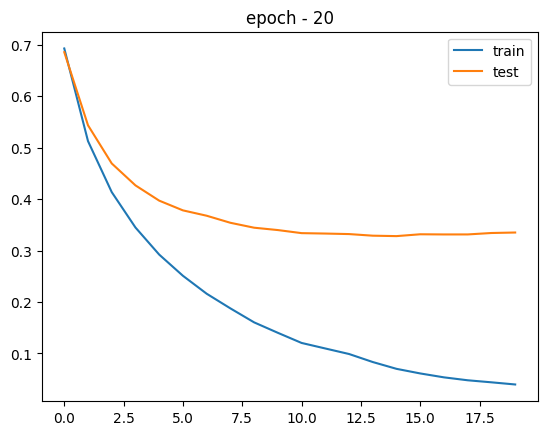

In [62]:
def train_iter(n = 10):    
    for i in range(n):
        train_loss = 0
        test_loss = 0
        for train_dataset,test_dataset in zip(train_datasets,test_datasets):
            train_losses = train(encoder,decoder,train_dataset,
                optimizer,criterion)
            test_losses = test(encoder,decoder,test_dataset,criterion)
            train_loss += sum(train_losses)
            test_loss += sum(test_losses)
        # don't forget to normalize the sum loss
        train_loss_hist.append(train_loss/train_size)
        test_loss_hist.append(test_loss/test_size)
        clear_output()
        plot_loss(train_loss_hist,test_loss_hist)
    save_checkpoint(encoder,decoder,optimizer,train_loss_hist,test_loss_hist,model_checkpoint_pth)
# train_iter(n = 20)

C:\Users\Leong Teng Man\AppData\Local\Temp\ipykernel_12524\716530133.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


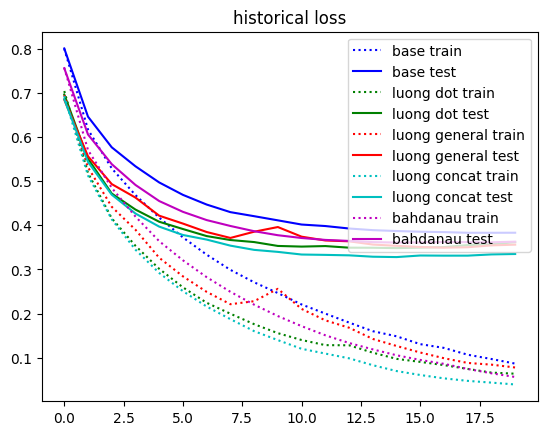

In [63]:
def fn():
    colors = iter("bgrcmykw")
    def plot(train_loss_hist,test_loss_hist,ax=plt,name = ""):
        color = next(colors)
        ax.plot(train_loss_hist,color,label=name + ' train',linestyle=":")
        ax.plot(test_loss_hist,color,label=name + ' test',linestyle="-")
    def helper(enc_ctor,dec_ctor,pth,name,ax):
        *_,train_loss_hist,test_loss_hist = load(enc_ctor,dec_ctor,pth)
        plot(train_loss_hist,test_loss_hist,ax,name=name)
    # helper()
    fig,ax = plt.subplots(1,1)
    helper(Encoder_RNN,Decoder_RNN,'model_checkpoint/seq2seq_RNN_small.pth',
           "base",ax)
    helper(Encoder_RNN,Luong_Decoder,'model_checkpoint/seq2seq_RNN_luong_dot_small.pth',
           "luong dot",ax)
    helper(Encoder_RNN,Luong_Decoder,'model_checkpoint/seq2seq_RNN_luong_general_small.pth',
           "luong general",ax)
    helper(Encoder_RNN,Luong_Decoder,'model_checkpoint/seq2seq_RNN_luong_concat_small.pth',
           "luong concat",ax)
    helper(Encoder_RNN,Bahdanau_Decoder,'model_checkpoint/seq2seq_RNN_bahdanau_small.pth',
           "bahdanau",ax)
    ax.set_title("historical loss")
    ax.legend()
    fig.show()
fn()

In [25]:
def predict(seq,encoder:Encoder_RNN,decoder:Decoder_RNN,MAX_LEN = 10):
    encoder.eval()
    decoder.eval()
    seq = seq.to(device).reshape(1,-1)
    Y,attentions = [],[]
    
    with torch.no_grad():
        encoder_outputs,encoder_hidden = encoder(seq,encoder.init_hidden().to(device))
        decoder_hidden = encoder_hidden
        cur_tkn = torch.tensor([[SOS_token]],device=device)
        
        while cur_tkn.item() != EOS_token and len(Y) < MAX_LEN:
            decoder_output, decoder_hidden,*attn = decoder(cur_tkn,decoder_hidden,encoder_outputs)
            
            if len(attn) != 0:
                attentions.append(attn[0])
            
            cur_tkn[0] = decoder_output.squeeze().argmax()
            Y.append(cur_tkn.item())
        
        if len(attentions) != 0:
            attentions = torch.cat(attentions).squeeze()

    return Y,attentions

In [26]:
def visualize_attention(attn,input_sent,out_sent):
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(attn,cmap='gray')
    range_len = lambda s: range(len(s))
    ax.set_yticks(range_len(out_sent))
    ax.set_xticks(range_len(input_sent))
    ax.set_yticklabels(output_lang.index2words(out_sent))
    ax.set_xticklabels(input_lang.index2words(input_sent))
    fig.show()

In [27]:
def random_pair(datasets):
    dataset = random.choice(datasets)
    input_sents,targets = next(iter(dataset))
    idx = random.choice(range(len(input_sents)))
    input_sent,target = input_sents[idx],targets[idx]
    return input_sent,target

input : je suis tellement occupe que je ne peux pas vous aider .
output : i am so busy that i can t help you .
translate : i am so busy that i can t help you . <EOS>
--------------------------------------------------
input : je suis tres content .
output : i am very pleased .
translate : i m very glad i have a doctor . <EOS>
--------------------------------------------------


C:\Users\Leong Teng Man\AppData\Local\Temp\ipykernel_12524\3415027784.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


input : avec plaisir .
output : you re welcome .
translate : i m by with a lot with a lot . <EOS>
--------------------------------------------------
input : je m habitue a cette nouvelle machine .
output : i m getting the hang of this new machine .
translate : i am used to it that out of this . <EOS>
--------------------------------------------------


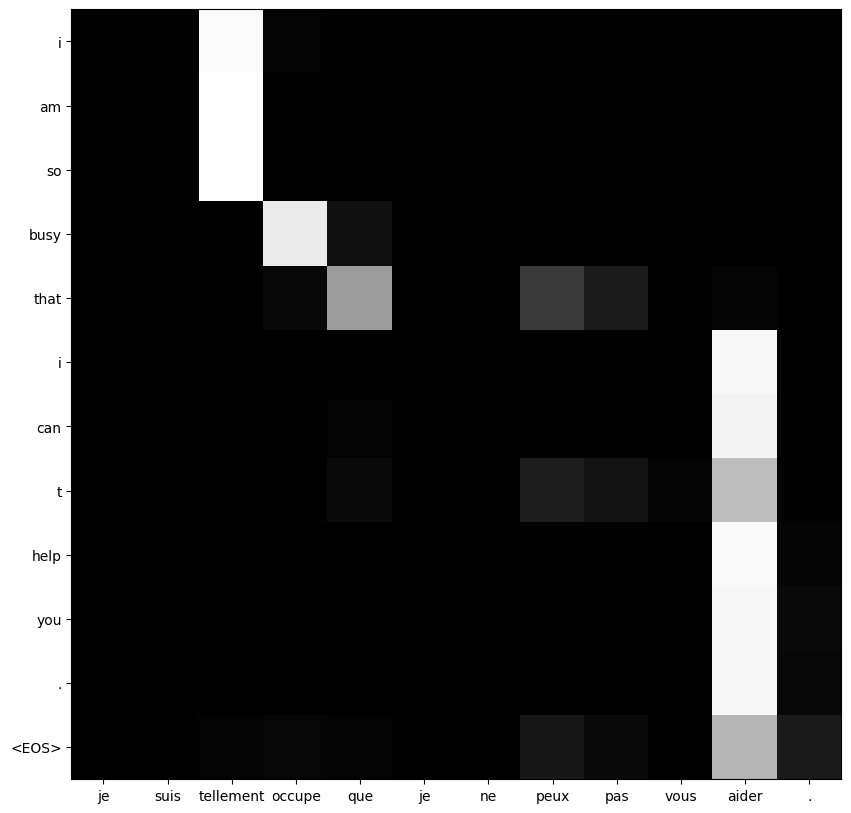

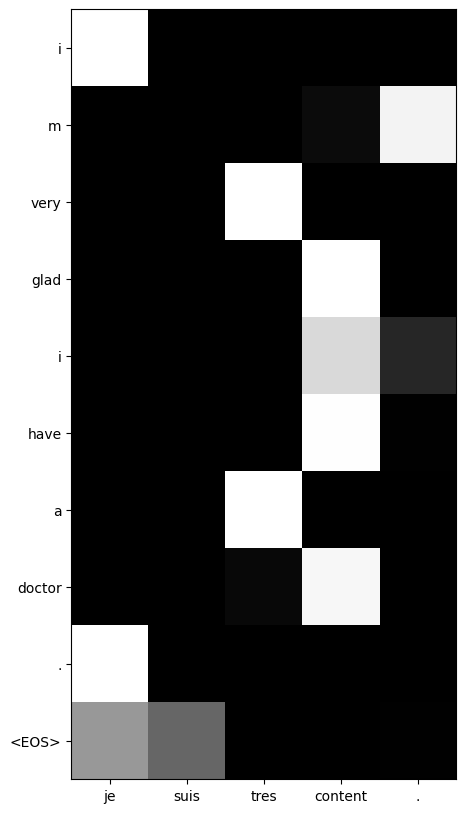

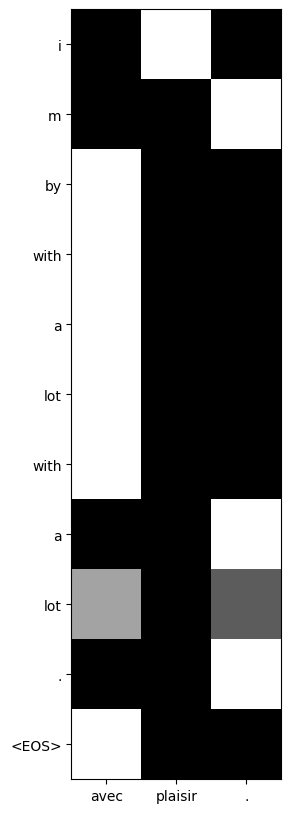

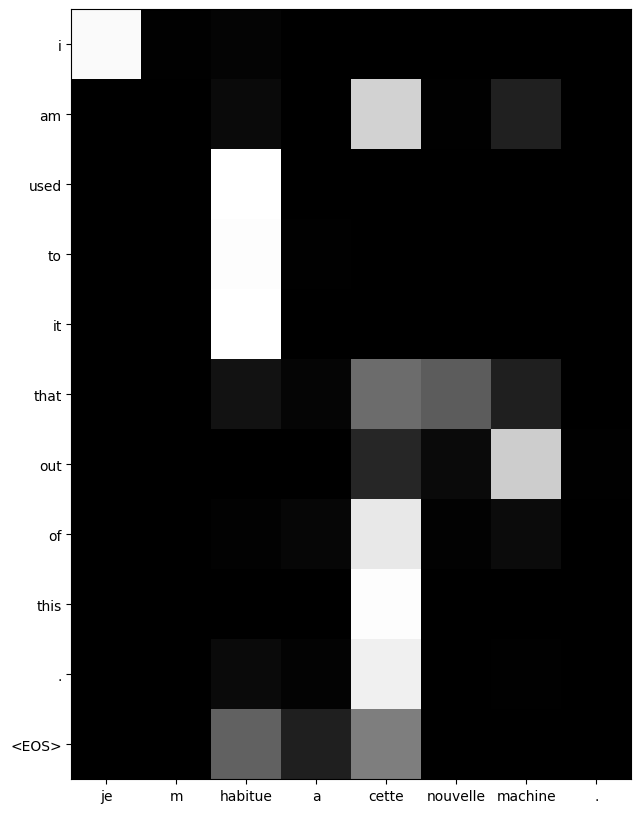

In [65]:
def fn(datasets, load_fn, n = 3):
    encoder,decoder,*_ = load_fn()
    for _ in range(n):
        input_sent,target = random_pair(datasets)
        out_sent,attentions = predict(input_sent,encoder,decoder,MAX_LEN = 100)

        
        numpy_from = lambda t: t.cpu().detach().numpy() if isinstance(t,torch.Tensor) else t
        input_sent = numpy_from(input_sent)
        target = numpy_from(target)
        out_sent = numpy_from(out_sent)
        attentions = numpy_from(attentions)
        print("input :", input_lang.index2sent(input_sent))
        print("output :",output_lang.index2sent(target))
        print("translate :" ,output_lang.index2sent(out_sent))
        if len(attentions) != 0:
            visualize_attention(attentions,input_sent,out_sent)
        print('-'*50)

    print('='*100)

# load_f = lambda: load(Encoder_RNN,Decoder_RNN,"model_checkpoint/seq2seq_RNN_small.pth")
# fn(test_datasets,load_f,n=1)
load_f = lambda: load(Encoder_RNN,Bahdanau_Decoder,"model_checkpoint/seq2seq_RNN_bahdanau_small.pth")
fn(test_datasets,load_f,n=1)
load_f = lambda: load(Encoder_RNN,Luong_Decoder,"model_checkpoint/seq2seq_RNN_luong_dot_small.pth")
fn(test_datasets,load_f,n=1)
load_f = lambda: load(Encoder_RNN,Luong_Decoder,"model_checkpoint/seq2seq_RNN_luong_general_small.pth")
fn(test_datasets,load_f,n=1)
load_f = lambda: load(Encoder_RNN,Luong_Decoder,"model_checkpoint/seq2seq_RNN_luong_concat_small.pth")
fn(test_datasets,load_f,n=1)